In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd


In [2]:
from model_prep import get_feature_name, model_transformer_train

In [117]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:61180" workers: 4 cores: 8, tasks: 0>,
 {0: <Nanny: tcp://127.0.0.1:61205, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:61202, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:61208, threads: 2>,
  3: <Nanny: tcp://127.0.0.1:61211, threads: 2>})

In [30]:
model_data = pd.read_pickle('Data/model_data.pkl')

In [31]:
model_data.columns

Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
       'district_code', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'lga_Njombe', 'year', 'month',
       'years_old', 'popbins'],
      dtype='object')

In [96]:
#model_data.drop(columns=['district_code', 'region_code'], inplace=True)
model_data['ten_years'] = model_data['years_old']>=10
model_data['ten_years'] = model_data['ten_years'].astype('int32')

In [33]:
class2 = model_data.loc[model_data['class']=='functional'].sample(7500, replace=False)
class0 = model_data.loc[model_data['class']=='non functional'].sample(7500, replace=False)
class1 = model_data.loc[model_data['class']=='functional needs repair'].sample(3000, replace=False)
split_data = pd.concat([class0, class1, class2])

In [8]:
split_data['class'] = split_data['class'].map({'functional':2, 'non functional':0, 'functional needs repair':1})

In [34]:
num_cols = ['gps_height', 'population']
cat_cols = ['basin', #'region_code', 'district_code', 
            'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'popbins']

In [35]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [36]:
def prep_train(unprepped_values, class_col):
    train_X, test_X, train_y, test_y = train_test_split(unprepped_values.drop(columns=[class_col]), 
                                                        unprepped_values[class_col], test_size=0.25, random_state=42)
    cols = train_X.columns
    id_train = list(train_X['id'].unique())
    train_Xct = CT.fit_transform(train_X)
    id_test = list(test_X['id'].unique())
    test_Xct = CT.transform(test_X)

    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    return train_Xf, train_y, test_Xf, test_y, id_train, id_test   

In [37]:
def prep_submit(unprepped_values):
    submit_X= unprepped_values
        
    submit_Xt = model_transformer_train(submit_X)
    submit_Xct = CT.transform(submit_Xt)

    cols = get_feature_name(CT)
    submit_Xf = pd.DataFrame(submit_Xct.todense(), columns=cols)
    
    return submit_Xf

In [97]:
train_Xf, train_y, test_Xf, test_y, id_train, id_test = prep_train(model_data, 'class')

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [18]:
rf = RandomForestClassifier(n_estimators=250, verbose=True)
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.2s finished


0.7947474747474748

In [98]:
rf = RandomForestClassifier(n_estimators=200, verbose=True,criterion='entropy')#gini', max_depth=3, max_leaf_nodes=4, min_samples_split=.2, min_samples_leaf=.05,
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished


0.7914478114478114

In [115]:
rf = RandomForestClassifier(n_estimators=200, verbose=True)#criterion='gini', max_depth=3, max_leaf_nodes=4, min_samples_split=.2, min_samples_leaf=.05,
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)
with joblib.parallel_backend('dask'):
    print(cross_val_score(rf, train_Xfpca, train_y))
test_Xfpca = pca.transform(test_Xf)
rf.score(test_Xfpca, test_y)

[0.79259259 0.78754209 0.79270483 0.78956229 0.78226712]


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished


<Figure size 2880x576 with 0 Axes>

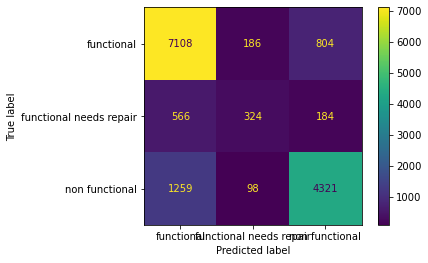

In [99]:
y_pred = rf.predict(test_Xfpca)
with joblib.parallel_backend('dask'):
    cm=confusion_matrix(test_y, y_pred, labels=rf.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
plt.figure(figsize=(40,8))
disp.plot()

In [100]:
checker = model_data.loc[model_data['id'].isin(id_test)].reset_index(drop=True)
checker.insert(0, value=y_pred, column='prediction')
checker

,prediction,id,class,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,...,water_quality,quantity,source,waterpoint_type,lga_Njombe,year,month,years_old,popbins,ten_years
0,non functional,19728,functional,2.382429,other,1328.771855,other,31.130847,-1.825359,Lake Victoria,...,soft,seasonal,rainwater_harvesting,communal standpipe,0,2011,7,12,1,1
1,functional,19816,non functional,1.802463,Dwsp,1156.911892,other,33.362410,-3.766365,Internal,...,soft,enough,machine_dbh,hand pump,0,2012,10,13,1,1
2,functional,6696,functional,1.000000,Private Individual,180.000000,other,38.363555,-6.636104,Wami-Ruvu,...,soft,enough,river,communal standpipe,0,2011,3,7,2,0
3,functional,41583,functional,2.220737,unknown,15.373716,unknown,39.812912,-7.889986,Rufiji,...,salty,enough,shallow_well,hand pump,0,2011,2,12,2,1
4,functional,57355,non functional,4.000000,other,1546.000000,other,36.618699,-3.293003,Pangani,...,soft,seasonal,rainwater_harvesting,other,0,2013,3,13,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,functional,49651,functional,2.198999,Rwssp,1323.396657,DWE,31.000000,-1.000000,Lake Victoria,...,soft,enough,shallow_well,hand pump,0,2012,10,13,1,1
14846,non functional,50998,functional,4.000000,gov_tanz,54.000000,DWE,39.046942,-5.061494,Pangani,...,soft,enough,river,communal standpipe,0,2011,8,6,4,0
14847,functional,44616,functional,1.357859,World Bank,11.000000,other,39.626009,-10.057499,Ruvuma-Southern_Coast,...,soft,enough,rainwater_harvesting,hand pump,0,2013,1,5,4,0
14848,functional,26640,functional,1.000000,0,25.000000,0,39.176480,-6.957098,Wami-Ruvu,...,soft,enough,machine_dbh,communal standpipe,0,2013,3,13,2,1


In [118]:
rf = RandomForestClassifier(n_estimators=200)
ada = AdaBoostClassifier(rf, n_estimators=100, random_state=42)
pca = PCA(n_components=100)
train_Xfpca = pca.fit_transform(train_Xf)

In [120]:
with joblib.parallel_backend('dask'):
    ada.fit(train_Xfpca, train_y)
test_Xfpca = pca.transform(test_Xf)
ada.score(test_Xfpca, test_y)

0.7909090909090909

In [125]:
sort(ada.feature_importances_)

NameError: name 'sort' is not defined

In [101]:
checker['correct']=checker['prediction']==checker['class']
checker['correct'] = checker['correct'].astype('int32')
checker

,prediction,id,class,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,...,quantity,source,waterpoint_type,lga_Njombe,year,month,years_old,popbins,ten_years,correct
0,non functional,19728,functional,2.382429,other,1328.771855,other,31.130847,-1.825359,Lake Victoria,...,seasonal,rainwater_harvesting,communal standpipe,0,2011,7,12,1,1,0
1,functional,19816,non functional,1.802463,Dwsp,1156.911892,other,33.362410,-3.766365,Internal,...,enough,machine_dbh,hand pump,0,2012,10,13,1,1,0
2,functional,6696,functional,1.000000,Private Individual,180.000000,other,38.363555,-6.636104,Wami-Ruvu,...,enough,river,communal standpipe,0,2011,3,7,2,0,1
3,functional,41583,functional,2.220737,unknown,15.373716,unknown,39.812912,-7.889986,Rufiji,...,enough,shallow_well,hand pump,0,2011,2,12,2,1,1
4,functional,57355,non functional,4.000000,other,1546.000000,other,36.618699,-3.293003,Pangani,...,seasonal,rainwater_harvesting,other,0,2013,3,13,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,functional,49651,functional,2.198999,Rwssp,1323.396657,DWE,31.000000,-1.000000,Lake Victoria,...,enough,shallow_well,hand pump,0,2012,10,13,1,1,1
14846,non functional,50998,functional,4.000000,gov_tanz,54.000000,DWE,39.046942,-5.061494,Pangani,...,enough,river,communal standpipe,0,2011,8,6,4,0,0
14847,functional,44616,functional,1.357859,World Bank,11.000000,other,39.626009,-10.057499,Ruvuma-Southern_Coast,...,enough,rainwater_harvesting,hand pump,0,2013,1,5,4,0,1
14848,functional,26640,functional,1.000000,0,25.000000,0,39.176480,-6.957098,Wami-Ruvu,...,enough,machine_dbh,communal standpipe,0,2013,3,13,2,1,1


In [102]:
pcacols = PCA()
pcacols.fit(train_Xf)
exp = pcacols.explained_variance_
exp
expdf = pd.DataFrame(exp.reshape(1,-1), columns=train_Xf.columns)
expdf.T.rename(columns={0:'var'}).sort_values('var', ascending=False)

,var
scaler__gps_height,4.595179e+08
scaler__population,1.039751e+02
ohe__x0_Internal,1.445722e+01
ohe__x0_Lake Nyasa,6.197390e+00
ohe__x0_Lake Rukwa,5.032624e+00
...,...
ohe__x15_4,4.565938e-24
ohe__x15_3,4.565938e-24
ohe__x15_2,4.565938e-24
ohe__x15_1,4.565938e-24


In [103]:
pd.DataFrame(rf.feature_importances_.reshape(1,-1), 
             columns=expdf.columns[:100]).T.rename(columns={0:'Importances'}).sort_values(by='Importances', 
                                                                           ascending=False).head(25)

,Importances
ohe__x2_per bucket,0.035316
ohe__x1_mono,0.033383
scaler__population,0.028874
ohe__x1_cemo,0.022658
ohe__x0_Wami-Ruvu,0.021410
ohe__x0_Lake Tanganyika,0.020631
ohe__x1_swn_80,0.017367
ohe__x1_other,0.015155
ohe__x1_other-handpump,0.014645
ohe__x1_afridev,0.013660


In [50]:
def Chi_sq_test(df, dependant, independant):
    #takes in the names of a dependant and independant variable (column), runs a chi squared test and then outputs 
    #a seaborn heatmap of the percent difference between the expected and actual values
    
    from scipy.stats import chi2_contingency
    from scipy.stats import chi2
    
    #create cotingency table
    count_table = df.groupby([dependant, independant])['id'].count().unstack()
    count_table.fillna(0, inplace=True)
    count_table = count_table.astype('int')
    
    #Chi Squared test is for only counts above 5, we are keeping the same ratio, but increasing min value to 5 in each column
    if count_table.isin(range(0,5)).any().any():
        for j in range(len(count_table.columns)):
            for i in range(len(count_table.index)):
                if count_table.iloc[i,j] < 1:
                    count_table.iloc[i,j] = 5
                    count_table.iloc[:,j] = count_table.iloc[:,j]*5
                elif count_table.iloc[i,j] <5:
                    count_table.iloc[:,j] = count_table.iloc[:,j]*(5/count_table.iloc[i,j])
    
    stat, p, dof, expected = chi2_contingency(count_table)
    
    #print test information
    print('P-Value = {}'.format(p))
    print('Chi Statistic = {}'.format(stat))
    print('Degrees of Freedom = {}'.format(dof))
    
    #caluclate and print heatmap
    plt.figure(figsize=(12,6))
    sns.heatmap(((count_table - expected) / count_table *100), annot=True, vmax=100, vmin=-100, fmt='.1f', 
                annot_kws={'rotation': 90}, cmap='viridis')
    plt.title('Percent Difference of Expected vs. Actual Classes per {}'.format(str.title(independant)))
    plt.show()

P-Value = 1.075491918563161e-22
Chi Statistic = 122.36676327119831
Degrees of Freedom = 8


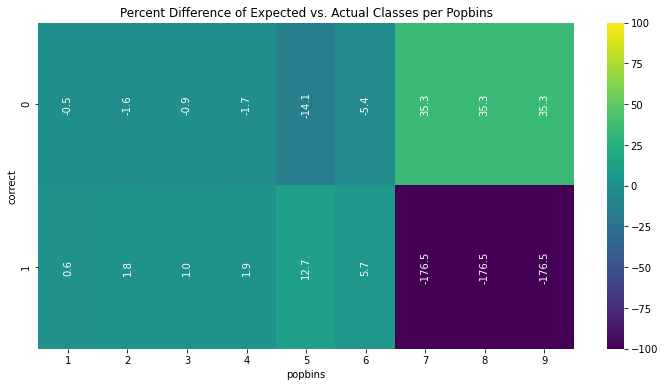

In [51]:
Chi_sq_test(checker, 'correct', 'popbins')

P-Value = 1.0966181662480626e-14
Chi Statistic = 98.09807709509907
Degrees of Freedom = 14


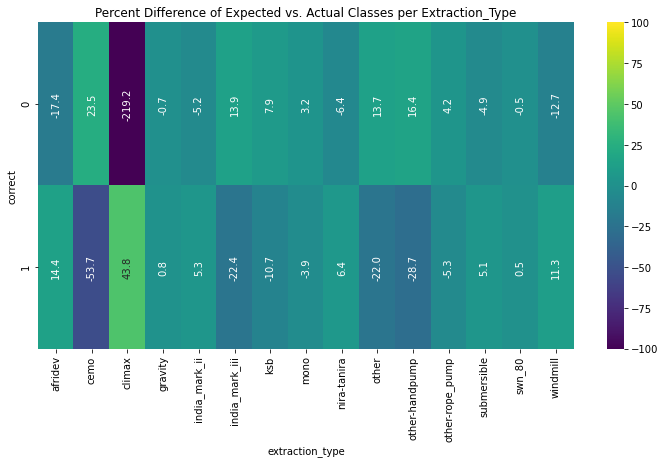

In [52]:
Chi_sq_test(checker, 'correct', 'extraction_type')

P-Value = 0.0001607718028141889
Chi Statistic = 30.670805028095625
Degrees of Freedom = 8


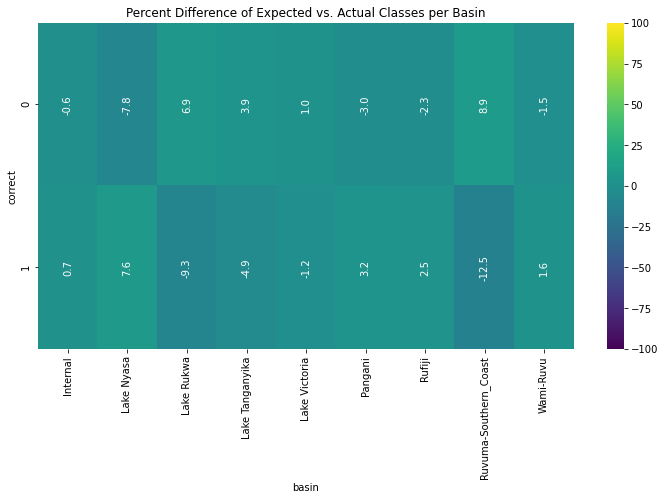

In [53]:
Chi_sq_test(checker, 'correct', 'basin')

P-Value = 0.2659154752234659
Chi Statistic = 11.144779666877227
Degrees of Freedom = 9


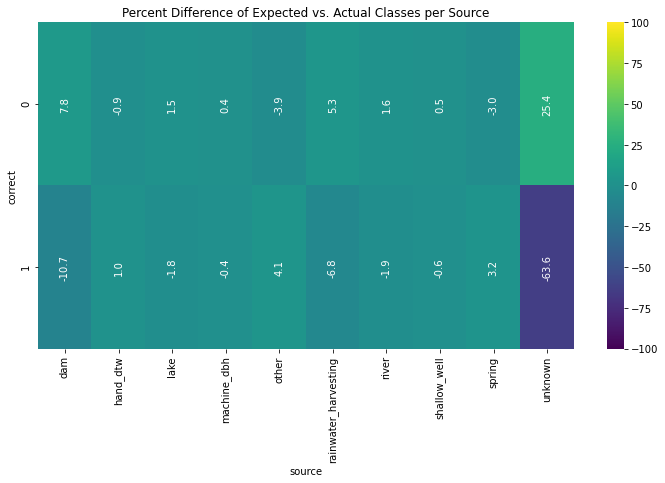

In [88]:
Chi_sq_test(checker, 'correct', 'source')

P-Value = 4.871232727630779e-20
Chi Statistic = 96.73530036616708
Degrees of Freedom = 4


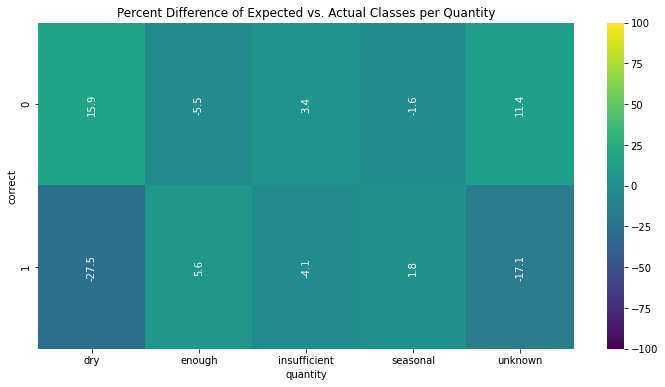

In [90]:
Chi_sq_test(checker, 'correct', '')

P-Value = 4.871232727630779e-20
Chi Statistic = 96.73530036616708
Degrees of Freedom = 4


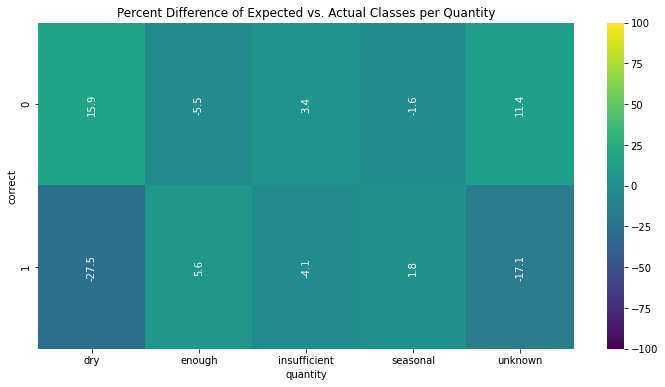

In [90]:
checker['old_bins']=pd.qcut(checker['years_old'], label=False)Chi_sq_test(checker, 'correct', '')

In [68]:
checker.columns

Index(['prediction', 'id', 'class', 'amount_tsh', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'subvillage', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity', 'source',
       'waterpoint_type', 'lga_Njombe', 'year', 'month', 'years_old',
       'popbins', 'correct'],
      dtype='object')

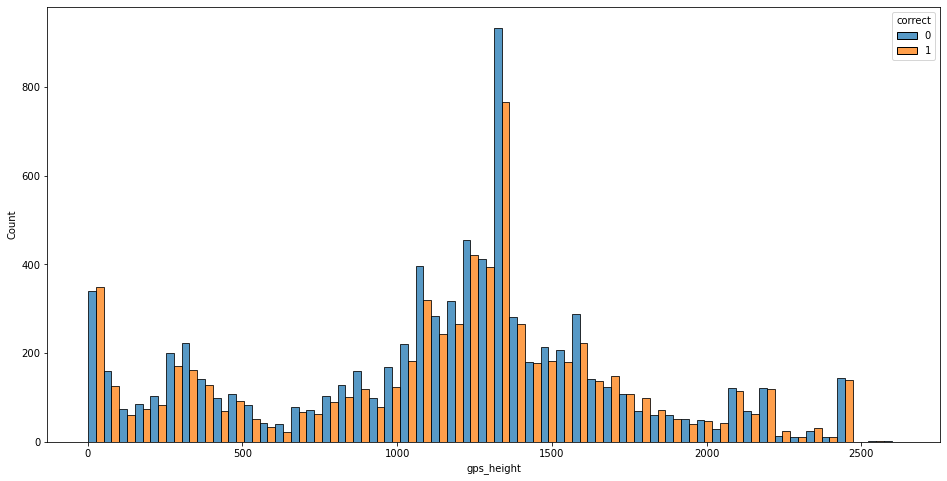

In [78]:
plt.figure(figsize=(16,8))
sns.histplot(data=checker, x='gps_height', hue='correct', multiple='dodge')#, element='poly', fill=False)
plt.show()

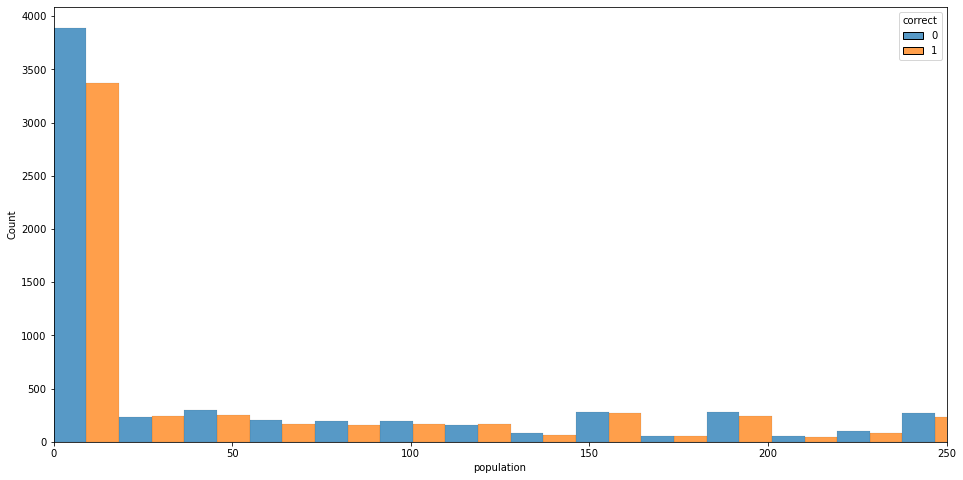

In [76]:
plt.figure(figsize=(16,8))
sns.histplot(data=checker, x='population', hue='correct', multiple='dodge')
plt.xlim(0,250)
plt.show()

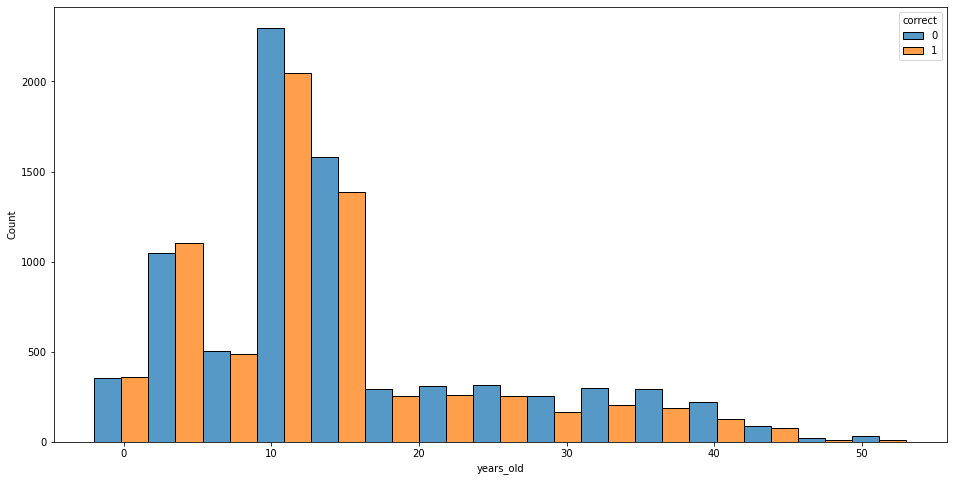

In [94]:
plt.figure(figsize=(16,8))
sns.histplot(data=checker, x='years_old', hue='correct', multiple='dodge', bins=15)
plt.show()

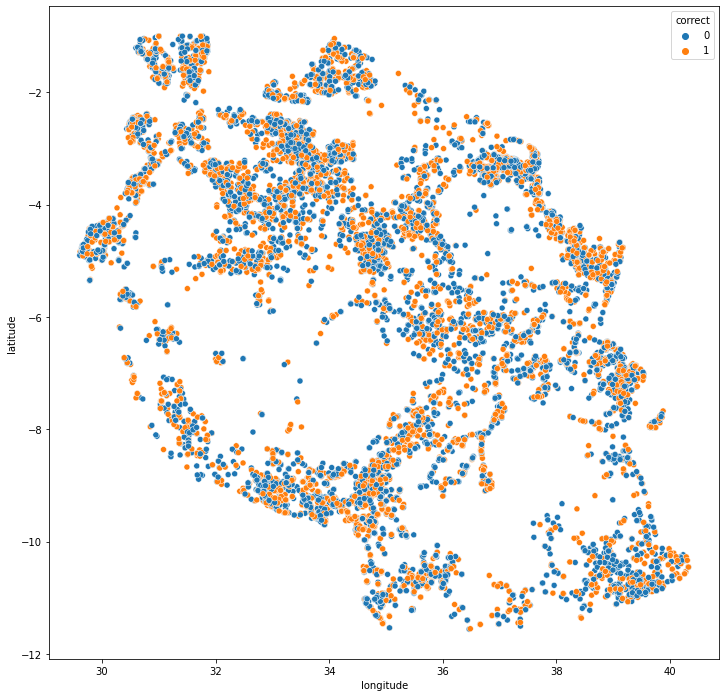

In [81]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=checker, y='latitude', hue='correct', x='longitude')
plt.show()